In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

# from statsmodels.graphics.tsaplots import plot_acf
# from statsmodels.tsa.stattools import adfuller
# from scipy.ndimage.interpolation import shift

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline

In [2]:
# Versões dos pacotes usados no notebook

%reload_ext watermark
%watermark -a "César S. Hooper/ Dezembro 2022" --iversions
!python --version

Author: César S. Hooper/ Dezembro 2022

cv2        : 4.5.4-dev
numpy      : 1.19.5
pandas     : 1.2.4
statsmodels: 0.12.2
matplotlib : 3.3.4
sklearn    : 0.24.1

Python 3.8.8


In [91]:
datos2 = pd.read_excel('micro emini ES 08-12 17_47.xls', sheet_name='4 hours - 1 M')[['HORA', 'CLOSE']]
datos3 = pd.read_excel('micro emini ES 08-13 17_10.xls', sheet_name='4 hours - 1 M')[['HORA', 'CLOSE']]
datos4 = pd.read_excel('micro emini ES 08-14 18_48.xls', sheet_name='4 hours - 1 M')[['HORA', 'CLOSE']]
datos5 = pd.read_excel('micro emini ES 08-15 19_08.xls', sheet_name='4 hours - 1 M')[['HORA', 'CLOSE']]

In [70]:
# datos concatenados 30 min
test = pd.concat([datos2, datos3, datos4, datos5], ignore_index=True)
test2 = pd.DataFrame()
test2['close12'] = datos2['CLOSE']
test2['close13'] = datos3['CLOSE']
test2['close14'] = datos4['CLOSE']
test2['close15'] = datos5['CLOSE']

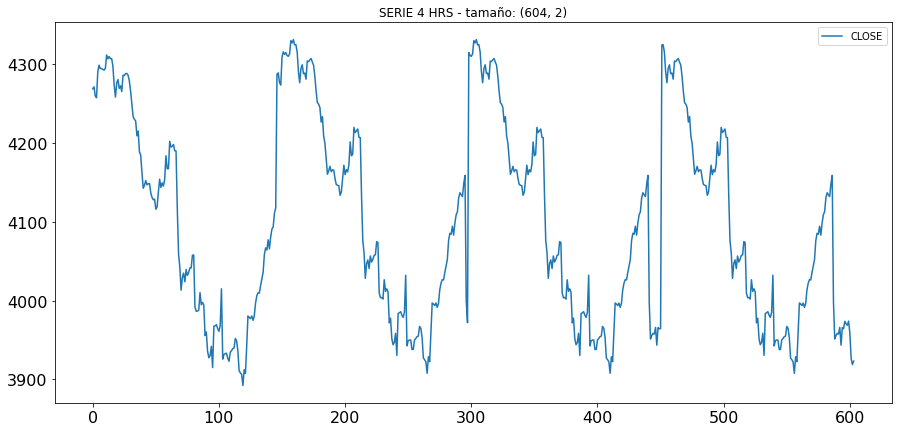

In [104]:
test.plot(figsize=(15,7), title='SERIE 4 HRS' + ' - tamaño: ' + str(test.shape), fontsize=16)
plt.show()

In [106]:
close = test['CLOSE']
close.isnull().sum(), close.mean(), close.std(), close.max(), close.min()

(0, 4097.386589403974, 127.59514858558452, 4331.5, 3892.25)

In [120]:
dataset = creaDataset(close, 5, 1, 2)
dataset.shape

(598, 6)

In [121]:
## creación y entrenamiento del modelo
y = dataset['target'];
X = dataset.drop('target', axis=1);

## Creación modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Vamos a escalar los datos. 
# Crea el objeto y fitea
scaler = StandardScaler()
scaler.fit(X_train)

# normaliza los datos. tf: transformados o escalados
X_train_tf = scaler.transform(X_train)
X_test_tf = scaler.transform(X_test)

# trinamento do modelo
rfr = RandomForestRegressor(n_estimators=1000, max_depth=50)
rfr.fit(X_train_tf, y_train)

# aplicação do modelo
y_train_pred= rfr.predict(X_train_tf)
y_test_pred = rfr.predict(X_test_tf)

In [122]:
resultados = pd.DataFrame(columns=['y_test_pred', 'y_test'])
resultados_train = pd.DataFrame(columns=['y_train', 'y_train_pred'])

resultados['y_test'] = y_test
resultados['y_test_pred'] = y_test_pred
resultados_train['y_train'] = y_train
resultados_train['y_train_pred'] = y_train_pred

In [123]:
linear_model_train = ols('y_train ~ y_train_pred', data=resultados_train).fit()
print(linear_model_train.summary())

                            OLS Regression Results                            
Dep. Variable:                y_train   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                 1.435e+04
Date:                Tue, 13 Dec 2022   Prob (F-statistic):               0.00
Time:                        23:42:59   Log-Likelihood:                -1870.3
No. Observations:                 418   AIC:                             3745.
Df Residuals:                     416   BIC:                             3753.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -85.1884     34.943     -2.438   

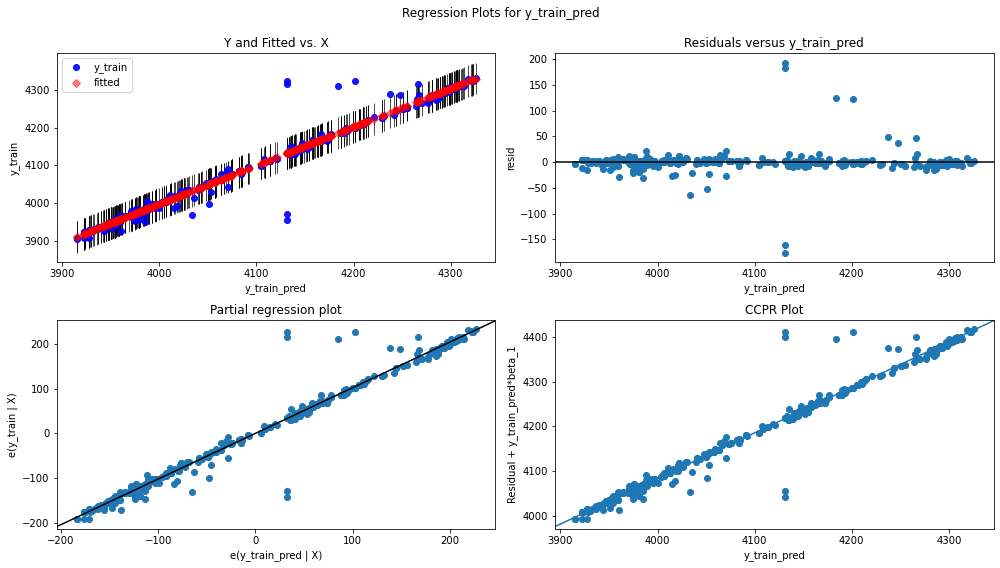

In [124]:
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(linear_model_train, 'y_train_pred', fig=fig)

In [125]:
linear_model = ols('y_test ~ y_test_pred', data=resultados).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 y_test   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     2503.
Date:                Tue, 13 Dec 2022   Prob (F-statistic):          9.16e-107
Time:                        23:43:11   Log-Likelihood:                -883.85
No. Observations:                 180   AIC:                             1772.
Df Residuals:                     178   BIC:                             1778.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -65.7775     83.067     -0.792      

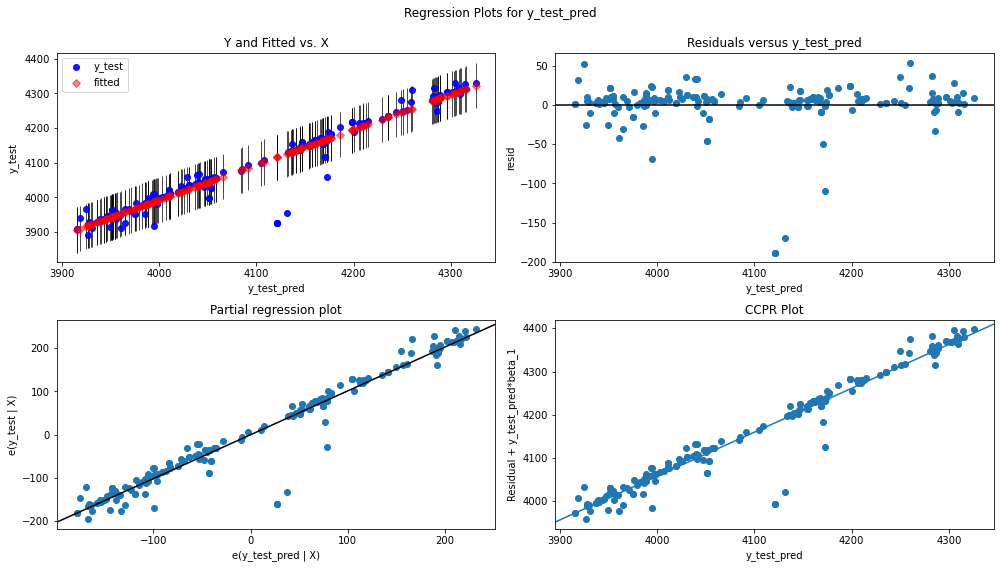

In [126]:
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(linear_model, 'y_test_pred', fig=fig)

In [33]:
def entropy(prob): [0 if k==0 else -np.log2(k)*k for k in prob].sum()

In [72]:
def creaDataset(dados, dim, step, pred):
    
    """
    Cria dataset a partir de uma serie de tempo ---
    
    -- dados: serie de tempo
    -- dim: dimensão do vector
    -- step: intercalado para seleção dos dados
    -- pred: dia target para prever
    -- return: retorna dataframe com vetores e target
    """
   
    N = len(dados)
    
    if ((dim-1)*step+pred)>N: print('Problemas com Dimensões dos objetos')
    
    dataset = pd.DataFrame(columns=['x'+str(u) for u in range(dim)])
    targets = []
    
    k = 0
    while True:
        
        if (k + (dim-1)*step + pred) == N: break 
        else:             
            dataset.loc[k] = [dados[u] for u in range(k, k + (dim-1)*step + 1, step)]
            targets.append(dados[k + (dim-1)*step + pred])
            k += 1    
    
    dataset['target'] = targets
    
    return dataset
        

In [73]:
def criaDataFrame(valorReal, valorPredicho, time, mediaMovil, dim=5):
    
    """
    crea los dataframes con los resultados de la regresión
    comando: cria_dataFrames(valor_real, valor_predicho, time, mediaMovil, Dimension)
    retorna DF 
    
    a. valorReal contiene los índices del dataframe    

    """
    
    
    # cargando los índices de los resultados
    indices = valorReal.index;
    
    # convirtiendo valorPredicho en Serie
    valorPredicho = pd.Series(valorPredicho, index=indices);
    
    # crea DF
    precios = pd.DataFrame(columns=['time', 'original', 'mediMovil', 'yTest', 'yPred', 'precioReal', 'precioPredicho'], index=indices)
    
    # corrección índices de resultados con valores reales
    tau = 5
    
    original = []
    mediaMovil = []
    
    
    real = []
    predicho = []
    tiempo = [] 
    
    for index in indices:
#         print(valorReal.loc[index] + mediaMovil.loc[index + tau])

        original.append(close.loc[index+tau])
        mediaMovil.append(mm.loc[index+tau])
    
        real.append(valorReal[index] + mediaMovil[index + tau]);
        predicho.append(valorPredicho[index] + mediaMovil[index + tau]);
#         tiempo.append(time[index + tau]);
    
    precios['original'] = original;
    precios['yTest'] = y_test;
    precios['yPred'] = y_test_pred;
    y['mediaMovil'] = mediaMovil
    
    
    precios['precioReal'] = real;
    precios['precioPredicho'] = predicho;
    precios['time'] = time.loc[indices];

    
    return precios